<a href="https://colab.research.google.com/github/arghyadeep99/Covid-19-Detection-from-X-Rays-using-CNN/blob/master/Corona%20Virus%20Detection%20from%20X-Rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Covid-19 Detection from X-Ray Scans using CNNs

##Disclaimer:

Before starting this notebook, kindly take strict note of the following:

1. The methods proposed here are in no way scientifically proven to help or detect Coronavirus convincingly. 

2. The work of this notebook should not be published in any kind of journals or research dataset. The research on Covid-19 is already burdened with community research that aren't proven to be effective and it is proving to be a menance. 

3. This notebook is just our novel attempt at trying to solve this global pandemic as deep learning researchers closely work with medical researchers to improve diagnosis. 

4. Recent researches have shown CT scans to be more helpful for detecting Corona Virus as compared to X-Ray scans. 

5. The dataset is scarce as it is hand curated, as abundance of scans aren't available for Corona positive and negative cases. 

**6. This notebook is a part of our Internal Assessment-1 under the course "Neural Network and Fuzzy Logic".**

#Objective and Motivation

COVID-19 attacks the epithelial cells that line our respiratory tract, we can use X-rays to analyze the health of a patient’s lungs. Given that nearly all hospitals have X-ray imaging machines, it could be possible to use X-rays to test for COVID-19 without the dedicated test kits.

A drawback is that X-ray analysis requires a radiology expert and takes significant time — which is precious when people are sick around the world. Therefore developing an automated analysis system is required to save medical professionals valuable time.

#Curating the Dataset

Picking up Covid-19 Positive cases from [this](https://github.com/ieee8023/covid-chestxray-dataset) repository with PA view. Chose one view as data is less and other views may in fact result in erroneous results. We will instead perform data augmentation on PA view data. For non-Covid-19 X-Ray scans, we will use data from Kaggle, and use healthy scans instead of, say like pneumonia, MERS, SARS, bronchitis, etc. 

The repository containing Covid-19  scans also has a file named 'metadata.csv'. This file is useful in extracting only the images we need. Since this is a Colab notebook, we have avoided mentioning the build_dataset.py script to obtain images. Overall, 25 images were gathered. So, we extract 25 healthy X-Ray scans from Kaggle. 

In [1]:
from google.colab import drive
drive.mount('/drive')
%cd /drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive
/drive


In [2]:
cd '/drive/My Drive/NNFL IA/dataset'

/drive/My Drive/NNFL IA/dataset


In [3]:
ls

covid/  healthy/


#Training Time!

In [4]:
#Importing required libraries 
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
#Initialize important parameters
INIT_LR = 1e-3
EPOCHS = 25
BS = 8
DATA = '/drive/My Drive/NNFL IA/dataset/'
COVID = DATA + 'covid/'
HEALTHY = DATA + 'healthy/'

In [6]:
print(list(paths.list_images(DATA)))

['/drive/My Drive/NNFL IA/dataset/covid/nCoV-radiol.2020200269.fig1-day7.jpeg', '/drive/My Drive/NNFL IA/dataset/covid/ryct.2020200028.fig1a.jpeg', '/drive/My Drive/NNFL IA/dataset/covid/ryct.2020200034.fig5-day4.jpeg', '/drive/My Drive/NNFL IA/dataset/covid/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', '/drive/My Drive/NNFL IA/dataset/covid/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', '/drive/My Drive/NNFL IA/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', '/drive/My Drive/NNFL IA/dataset/covid/nejmoa2001191_f1-PA.jpeg', '/drive/My Drive/NNFL IA/dataset/covid/radiopedia-covid-19-pneumonia-2.jpg', '/drive/My Drive/NNFL IA/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg', '/drive/My Drive/NNFL IA/dataset/covid/nejmc2001573_f1b.jpeg', '/drive/My Drive/NNFL IA/dataset/covid/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', '/drive/My Drive/NNFL IA/dataset/covid/nejmc2001573_f1a.jpeg', '/drive/My Driv

In [0]:
# Initialize the list of images and labels

imagePaths = list(paths.list_images(DATA))
data = []
labels = []
# loop over the image paths
for img_path in imagePaths:
	# extract the class label from the filename
	label = img_path.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(img_path)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]

data = np.array(data) / 255.0
labels = np.array(labels)


# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print(labels)

In [0]:

# 80% training, 20% split

(trainX, valX, trainY, valY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
#trainAug = ImageDataGenerator(
#	rotation_range=15,
#	fill_mode="nearest")



# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

train_datagen = ImageDataGenerator(rotation_range = 15, fill_mode='nearest')
  
train_generator = train_datagen.flow(trainX, trainY, 
                                      shuffle=True, 
                                      seed=42,
                                      batch_size=BS)


In [50]:
IMG_SHAPE = (224,224,3)

# Create the base model from the pre-trained model MobileNet
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()
print("Number of layers are: ", len(base_model.layers))
layer_names=list(base_model.layers)
layer_names=[str(l) for l in layer_names]
layers_names=[]
for i in layer_names:
  i=i.split(".")
  #print(i)
  i[5]=i[5].split(" ")[0]
  i[0]=i[0][1:]
  i='.'.join(i)
  layers_names.append(i)
  #print(i)
print(layers_names)
print(len(layers_names))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.AveragePooling2D(pool_size = (4,4), data_format=None),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Flatten(name="flatten2"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [0]:
#Fine tuning done by unfreezing Batch Normalization layer and then retraining them. 

do_fine_tuning = True #@param {type:"boolean"}
#fine_tune_at=145
if do_fine_tuning:
  base_model.trainable=True
  j=1
  for layer,model_layer in zip(base_model.layers[0:176],layers_names):
    if model_layer!='tensorflow.python.keras.layers.normalization.BatchNormalization':
      layer.trainable =  False
    else:
      layer.trainable = True
      print("BN layer{} unfreezed.".format(j))
      j=j+1
else:
  base_model.trainable=False

In [53]:
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=INIT_LR, decay = INIT_LR / EPOCHS), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 512)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1, 512)         262656    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
flatten2 (Flatten)           (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [54]:
EPOCHS=30 #param {type:"integer"}
init_epoch=0
filepath = '/drive/My Drive/NNFL IA/covid-19 xray.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoints_list = [checkpoint]
history = model.fit_generator(train_generator,
                            initial_epoch = init_epoch,
                            steps_per_epoch= len(trainX) // BS,
                            validation_data= (valX, valY),
                            validation_steps=len(valX) // BS,
                            epochs=EPOCHS,
                            callbacks=checkpoints_list, 
                            verbose=0)

  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /drive/My Drive/NNFL IA/covid-19 xray.hdf5

Epoch 00002: val_accuracy improved from 0.50000 to 0.62500, saving model to /drive/My Drive/NNFL IA/covid-19 xray.hdf5

Epoch 00003: val_accuracy did not improve from 0.62500

Epoch 00004: val_accuracy did not improve from 0.62500

Epoch 00005: val_accuracy improved from 0.62500 to 0.87500, saving model to /drive/My Drive/NNFL IA/covid-19 xray.hdf5

Epoch 00006: val_accuracy did not improve from 0.87500

Epoch 00007: val_accuracy did not improve from 0.87500

Epoch 00008: val_accuracy did not improve from 0.87500

Epoch 00009: val_accuracy did not improve from 0.87500

Epoch 00010: val_accuracy did not improve from 0.87500

Epoch 00011: val_accuracy did not improve from 0.87500

Epoch 00012: val_accuracy did not improve from 0.87500

Epoch 00013: val_accuracy did not improve from 0.87500

Epoch 00014: val_accuracy did not improve from 0.87500

E

In [55]:
from keras.models import load_model
#model.save(filepath)
model=tf.keras.models.load_model(filepath)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 512)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1, 512)         262656    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
flatten2 (Flatten)           (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

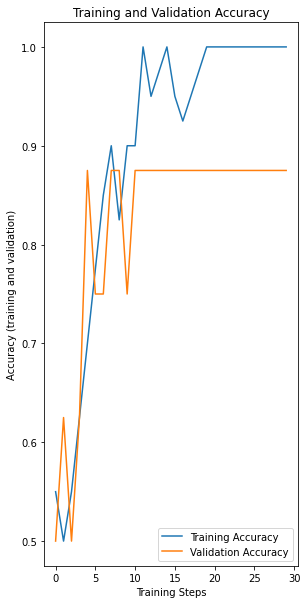

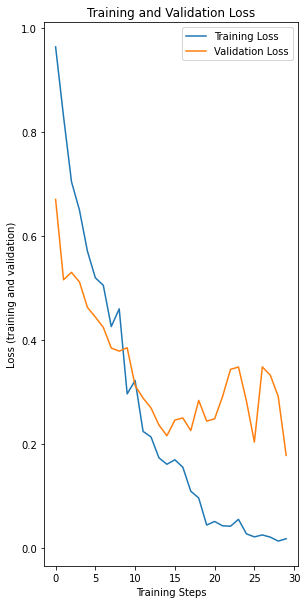

Training accuracy is: 100.0%
Validation accuracy is: 87.5%


In [56]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

print("Training accuracy is: {}%".format(acc[-1]*100))
print("Validation accuracy is: {}%".format(val_acc[-1]*100))

In [0]:
# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(DATA, filename))
    img = cv2.resize(img, (224,224) )
    img = img /255
    
    return img

classes = ['covid', 'healthy']
def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: covid, file: 1-s2.0-S0929664620300449-gr2_lrg-a.jpg
0
PREDICTED: class: covid, confidence: 0.565385


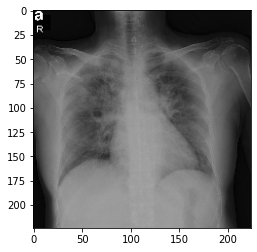

<Figure size 432x288 with 0 Axes>

SOURCE: class: covid, file: nejmoa2001191_f3-PA.jpeg
1
PREDICTED: class: covid, confidence: 0.501909


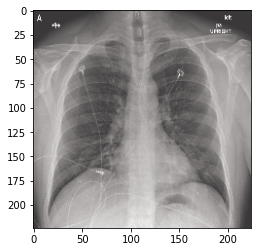

SOURCE: class: healthy, file: person525_bacteria_2216.jpeg
2
PREDICTED: class: healthy, confidence: 0.596006


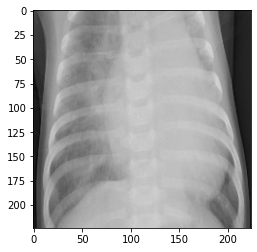

<Figure size 432x288 with 0 Axes>

SOURCE: class: covid, file: ryct.2020200034.fig5-day0.jpeg
3
PREDICTED: class: covid, confidence: 0.637803


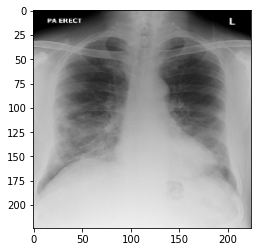

<Figure size 432x288 with 0 Axes>

SOURCE: class: covid, file: auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
4
PREDICTED: class: covid, confidence: 0.575467


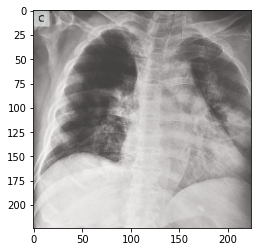

<Figure size 432x288 with 0 Axes>

SOURCE: class: healthy, file: person438_bacteria_1893.jpeg
5
PREDICTED: class: healthy, confidence: 0.721625


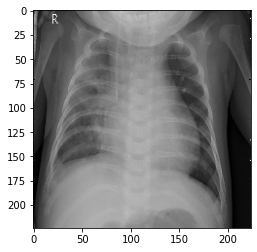

<Figure size 432x288 with 0 Axes>

SOURCE: class: healthy, file: person651_bacteria_2543.jpeg
6
PREDICTED: class: healthy, confidence: 0.681789


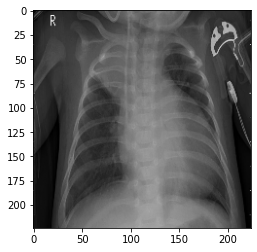

<Figure size 432x288 with 0 Axes>

SOURCE: class: covid, file: 1-s2.0-S0929664620300449-gr2_lrg-b.jpg
7
PREDICTED: class: covid, confidence: 0.686170


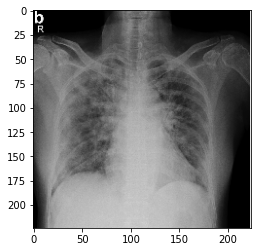

<Figure size 432x288 with 0 Axes>

SOURCE: class: healthy, file: person612_bacteria_2478.jpeg
8
PREDICTED: class: healthy, confidence: 0.694145


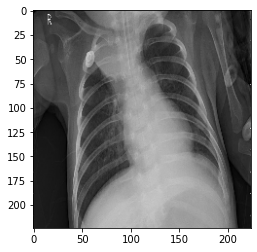

<Figure size 432x288 with 0 Axes>

SOURCE: class: covid, file: nejmc2001573_f1a.jpeg
9
PREDICTED: class: healthy, confidence: 0.519739


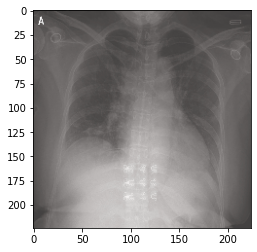

<Figure size 432x288 with 0 Axes>

In [58]:
for idx, filename in enumerate(random.sample(list(paths.list_images(DATA)),10)):
    print("SOURCE: class: %s, file: %s" % (filename.split('/')[5], filename.split('/')[6]))
    print(idx)
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [59]:
#Print Performance Report
pred_values = model.predict(valX, batch_size=BS)
pred_values = np.argmax(pred_values, axis=1)

print(classification_report(valY.argmax(axis=1), pred_values, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      0.80      0.89         5
     healthy       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [60]:
#Printing Confusion Matrix

cm = confusion_matrix(valY.argmax(axis=1), pred_values)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[4 1]
 [0 5]]
acc: 0.9000
sensitivity: 0.8000
specificity: 1.0000
